# Fake News Detection

In [218]:
import pandas as pd
import numpy as np
import pickle
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#### Functions & Classes

In [219]:
def remove_stopwords(l):
    """
    Remove English stopwords from a list of strings.

    Args:
        l: A list of strings.

    Returns:
        A list of strings after stop words are removed.
    """
    
    stop_words = stopwords.words('english')
    
    return [w for w in l if w not in stop_words]

In [220]:
def tokenize(s):
    """
    Tokenize a string.

    Args:
        s: String to be tokenized.

    Returns:
        A list of words as the result of tokenization.
    """
    return word_tokenize(s)

In [221]:
def stem_and_lemmatize(l):
    """
    Perform stemming and lemmatization on a list of words.

    Args:
        l: A list of strings.

    Returns:
        A list of strings after being stemmed and lemmatized.
    """
    ps = PorterStemmer ()
    stemmed = [ps.stem(w) for w in l]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(w) for w in stemmed]
    return lemmatized

In [222]:
def pre_processor(s):
    """
    Perform all pre processing before Count Vectorizer

    Args:
      s: series of texts

    Returns:
        A list of strings after processing.
    """
    
    s = s.str.replace(r'[^\w\s]+', '')
    s = s.str.lower()
    
    return [' '.join(stem_and_lemmatize(remove_stopwords(tokenize(el)))) for el in s] 

In [223]:
def ml_fit(X,y,model,parameters,modelname):
    
    pipe_model = Pipeline([('vect', CountVectorizer(dtype=np.int16)),\
                     ('clf', model)])

    model = GridSearchCV(pipe_model, parameters, cv=5)
    model.fit(X, y)

    pickle.dump(model, open(modelname + '.sav', 'wb'))
    
    return model

In [224]:
def ml_fit2(X,y,model,parameters,modelname):
    
    model = GridSearchCV(model, parameters, cv=5)
    model.fit(X, y)

    pickle.dump(model, open(modelname + '.sav', 'wb'))
    
    return model

In [225]:
def model_eval(X_test,y_test, model,modelname):
    y_pred = model.predict(X_test)

    print(modelname ,'Optimal Parameters :       ', model.cv_results_ ['params'] [np.argmin(model.cv_results_['rank_test_score'])])
    print(modelname ,'Cross Validation Accuracy: ', round(model.cv_results_ ['mean_test_score'] [np.argmin(model.cv_results_['rank_test_score'])]*100,2), '%', '\n')

    print(modelname ,'Accuracy:  ', round(model.score(X_test, y_test) * 100,2) , '%')
    print(modelname ,'Precision: ', round(precision_score(y_test,y_pred) *100,2), '%')
    print(modelname ,'Recall:    ', round(recall_score(y_test,y_pred) *100,2), '%')      
    print(modelname ,'F1-Score:  ', round(f1_score(y_test,y_pred),2), '\n')  

    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d', cmap="YlGnBu")
    plt.title(modelname +' Confusion Matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Reality')
    plt.xticks([0.5,1.5], labels=['fake', 'true'])
    plt.yticks([0.5,1.5], labels=['fake', 'true'], va='center')
    plt.show()

#### Dataset Import and Cleaning

#### [Kaggle - All the News](https://www.kaggle.com/snapcrack/all-the-news)

In [226]:
#All the news Dataset from Kaggle with 150K articles from 15 different publications ("true news")

all_news1 = pd.read_csv('all-the-news/articles1.csv', index_col=0)
all_news2 = pd.read_csv('all-the-news/articles2.csv', index_col=0)
all_news3 = pd.read_csv('all-the-news/articles3.csv', index_col=0)
all_news = pd.concat([all_news1, all_news2, all_news3])

all_news = all_news.loc[~all_news.title.isnull()] 

tn_df = all_news.loc[:, ['title', 'content']]
tn_df['target'] = 0 # insert target column with value 0 - is not fake news
tn_df = tn_df.sample(12403) # sample 12000 samples to have a balanced DS with the fake news
tn_df.rename(columns={'content':'text'}, inplace=True) #align column names with fake news
tn_df.isnull().sum() # Validate there are no NaN present

title     0
text      0
target    0
dtype: int64

#### [Kaggle - Getting Real about Fake News](https://www.kaggle.com/mrisdal/fake-news)

In [227]:
# Fake news dataset from Kaggle
fake_news = pd.read_csv('fake.csv')

# get only relevant columns & english language
fn_df=fake_news.loc[fake_news.language == 'english',['title','text']] 
fn_df['target'] = 1 # insert target column with value 1 - is fake news
fn_df.isnull().sum() # Validate for NaN

title     680
text       46
target      0
dtype: int64

###### There are null values, but they do not coincide in title/text. The number of rows is small compared to the dataset size, but given we have both columns, we will fill text with title and vice versa in the case where NaN exists

In [228]:
fn_df.text.fillna(fn_df.title, inplace=True)
fn_df.title.fillna(fn_df.text, inplace=True)
fn_df.isnull().sum()

title     0
text      0
target    0
dtype: int64

In [229]:
# Creating dataset with both True and Fake News
n_df = pd.concat([fn_df, tn_df])
n_df.target.value_counts()

1    12403
0    12403
Name: target, dtype: int64

#### Text Pre-Processing

In [230]:
n_df['text2'] = pre_processor(n_df.text)
n_df['title2'] = pre_processor(n_df.title)

### Machine Learning - Using Article Text as a Feature

##### Define Features & Target

In [231]:
X = n_df.text2
y = n_df.target

##### Define Train and Test

In [232]:
# reserved 5% (~1500 examples) for final testing, rest is for Train & Hyperparameter tuning with CV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

##### Naive-Bayes

NB_Text Optimal Parameters :        {'vect__max_df': 1.0, 'vect__min_df': 1}
NB_Text Cross Validation Accuracy:  86.93 % 

NB_Text Accuracy:   87.59 %
NB_Text Precision:  90.66 %
NB_Text Recall:     84.36 %
NB_Text F1-Score:   0.87 



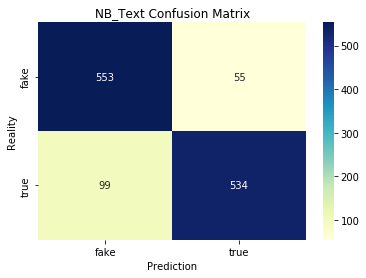

In [233]:
parameters = {'vect__min_df':[0.01,0.02,1], 'vect__max_df':[0.1, 0.2, 1.0]}
model1 = ml_fit(X_train, y_train, MultinomialNB(),parameters, 'NB_Text')
model_eval(X_test,y_test,model1,'NB_Text')

##### Linear SVM

In [ ]:
parameters = {'clf__C':[1.0, 10, 100]}
model2 = ml_fit(X_train, y_train,SVC(kernel='linear'), parameters, 'SVM_Text')
model_eval(X_test,y_test,model2,'SVM_Text')

##### Logistic Regression

In [ ]:
parameters = {'clf__C':[0.01,0.1,1.0,10,100,1000]}
model3 = ml_fit(X_train, y_train,LogisticRegression(), parameters, 'LogR_Text')
model_eval(X_test,y_test,model3,'LogR_Text')

##### Gradient Boosting

In [ ]:
parameters = {'clf__learning_rate':[1], 'clf__n_estimators':[100]}
model4 = ml_fit(X_train, y_train,GradientBoostingClassifier(), parameters, 'GrBoost_Text')
model_eval(X_test,y_test,model4,'GrBoost_Text')

##### Decision Tree

In [ ]:
parameters = {'clf__max_depth':[100,500,None]}
model5 = ml_fit(X_train, y_train,DecisionTreeClassifier(), parameters, 'DecTree_Text')
model_eval(X_test,y_test,model5,'DecTree_Text')

##### Random Forest

In [ ]:
parameters = {'clf__max_depth':[None]}
model6 = ml_fit(X_train, y_train,RandomForestClassifier(), parameters, 'RForest_Text')
model_eval(X_test,y_test,model6,'RForest_Text')

### Machine Learning - Using Article TITLE as a Feature

##### Define Features & Target

In [ ]:
X = n_df.title2
y = n_df.target

##### Define Train and Test

In [ ]:
# reserved 5% (~1500 examples) for final testing, rest is for Train & Hyperparameter tuning with CV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

##### Naive-Bayes

In [ ]:
parameters = {'vect__min_df':[0.01,0.02,1], 'vect__max_df':[0.1, 0.2, 1.0]}
model7 = ml_fit(X_train, y_train,MultinomialNB(),parameters, 'NB_Title')
model_eval(X_test,y_test,model7,'NB_Title')

##### Linear SVM

In [ ]:
parameters = {'clf__C':[1.0, 10, 100]}
model8 = ml_fit(X_train, y_train,SVC(kernel='linear'), parameters, 'SVM_Title')
model_eval(X_test,y_test,model8,'SVM_Title')

##### Logistic Regression

In [ ]:
parameters = {'clf__C':[0.01,0.1,1.0,10,100,1000]}
model9 = ml_fit(X_train, y_train,LogisticRegression(), parameters, 'LogR_Title')
model_eval(X_test,y_test,model9,'LogR_Title')

##### Gradient Boosting

In [ ]:
parameters = {'clf__learning_rate':[0.1,1], 'clf__n_estimators':[300]}
model10 = ml_fit(X_train, y_train,GradientBoostingClassifier(), parameters, 'GrBoost_Title')
model_eval(X_test,y_test,model10,'GrBoost_Title')

##### Decision Tree

In [ ]:
parameters = {'clf__max_depth':[200,400,500,1000,None]}
model11 = ml_fit(X_train, y_train,DecisionTreeClassifier(), parameters, 'DecTree_Title')
model_eval(X_test,y_test,model11,'DecTree_Title')

##### Random Forest

In [ ]:
parameters = {'clf__n_estimators':[100,200,300], 'clf__max_depth':[2,3,4,None]}
model12 = ml_fit(X_train, y_train,RandomForestClassifier(), parameters, 'RForest_Title')
model_eval(X_test,y_test,model12,'RForest_Title')

### Machine Learning - Using BOTH Article TEXT and TITLE as Features

##### Define Features & Target

In [ ]:
X = n_df.loc[:,['text2','title2']]
y = n_df.target

##### Count Vectorize and Tfidf

In [ ]:
#Pre vectorizing because have 2 features, easier this way
vect = TfidfVectorizer()
X_vect = sp.hstack(X.apply(lambda col: vect.fit_transform(col)))

##### Define Train and Test

In [ ]:
# reserved 5% (~1500 examples) for final testing, rest is for Train & Hyperparameter tuning with CV
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.05)

##### Naive-Bayes

In [ ]:
parameters = {'alpha':[1]}
model13 = ml_fit2(X_train, y_train, MultinomialNB(),parameters, 'NB_Both')
model_eval(X_test,y_test,model13,'NB_Both')

##### Linear SVM

In [ ]:
parameters = {'C':[1.0]}
model14 = ml_fit2(X_train, y_train,SVC(kernel='linear'), parameters, 'SVM_Both')
model_eval(X_test,y_test,model14,'SVM_Both')

##### Logistic Regression

In [ ]:
parameters = {'C':[0.01,0.1,1.0,10,100,1000]}
model15 = ml_fit2(X_train, y_train,LogisticRegression(), parameters, 'LogR_Both')
model_eval(X_test,y_test,model15,'LogR_Both')

##### Gradient Boosting

In [ ]:
parameters = {'learning_rate':[1], 'n_estimators':[100]}
model16 = ml_fit2(X_train, y_train,GradientBoostingClassifier(), parameters, 'GrBoost_Both')
model_eval(X_test,y_test,model16,'GrBoost_Both')

##### Decision Tree

In [ ]:
parameters = {'max_depth':[500,1000,None]}
model17 = ml_fit2(X_train, y_train,DecisionTreeClassifier(), parameters, 'DecTree_Both')
model_eval(X_test,y_test,model17,'DecTree_Both')

##### Random Forest

In [ ]:
parameters = {'n_estimators':[300], 'max_depth':[None]}
model18 = ml_fit2(X_train, y_train,RandomForestClassifier(), parameters, 'RForest_Both')
model_eval(X_test,y_test,model18,'RForest_Both')

### Testing CoronaVirus Fake News

In [ ]:
covid = pd.read_csv('corona_fake.csv', sep=';', index_col=0)

In [ ]:
covid

In [ ]:
covid['text2'] = pre_processor(covid.Text)
covid['title2'] = pre_processor(covid.Title)

In [ ]:
covid

### Article Text Model

In [ ]:
X_covid = covid.text2
y_covid = np.array(covid.IsFake)

In [ ]:
y_pred_covid = model3.predict(X_covid)

In [ ]:
y_pred_covid

In [ ]:
covid['pred'] = y_pred_covid

In [ ]:
covid.loc[:,['title2','IsFake','pred']]

In [ ]:
accuracy_covid = sum(y_covid==y_pred_covid)/len(y_covid)*100
accuracy_covid

In [ ]:
model_eval(X_covid,y_covid,model3,'LogReg Covid Examples')

In [ ]:
X_covid = covid.title2

In [ ]:
y_pred_covid = model9.predict(X_covid)

In [ ]:
y_pred_covid

In [ ]:
y_covid

In [ ]:
accuracy_covid = sum(y_covid==y_pred_covid)/len(y_covid)*100
accuracy_covid